# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -U scikit-learn --user

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

### Чтение и изучение данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<b>Выводы:</b> 
 - В данных присутствуют пропуски
 - Столбец "NumberOf Pictures" не имеет вещественных значений
 - в столбце "Power" наблюдается скошенность ,т.к среднее и медианное значение имеют сильное различие 


### Чистка данных

Проверка на дубликаты

In [6]:
data.duplicated().sum()

4

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

Удаление неинформативных признаков

In [8]:
#data = data.drop(['NumberOfPictures', 'DateCrawled', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCreated'], axis=1)
data['date_registration'] = data['RegistrationYear'].astype('str') +'-'+ data['RegistrationMonth'].astype('str')

In [9]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d')

In [10]:
date_registration = data[(data['RegistrationMonth'] > 0) & ((data['RegistrationYear'] < 2200) & (data['RegistrationYear'] > 1900))][['date_registration', 'LastSeen', 'RegistrationMonth']].copy()
date_registration['date_registration'] = pd.to_datetime(date_registration['date_registration'], format='%Y-%m')

In [11]:
#троки в которых дата регистрации первышает дату последнего посещения
date_registration = date_registration[date_registration['date_registration'] > date_registration['LastSeen']]
date_registration

,date_registration,LastSeen,RegistrationMonth
22,2018-05-01,2016-03-31 01:16:33,5
26,2017-04-01,2016-03-16 09:16:46,4
31,2016-06-01,2016-03-29 17:43:07,6
35,2016-04-01,2016-03-08 09:44:50,4
48,2017-01-01,2016-03-31 21:47:44,1
...,...,...,...
354165,2016-08-01,2016-04-06 05:46:43,8
354194,2016-08-01,2016-03-13 02:45:51,8
354199,2018-06-01,2016-03-29 15:45:04,6
354285,2017-07-01,2016-04-05 11:48:09,7


In [12]:
data = data.drop(date_registration.index).reset_index(drop=True)

In [13]:
data = data.drop(['NumberOfPictures', 'DateCrawled', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCreated', 'date_registration'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338511 entries, 0 to 338510
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             338511 non-null  int64 
 1   VehicleType       316836 non-null  object
 2   RegistrationYear  338511 non-null  int64 
 3   Gearbox           320028 non-null  object
 4   Power             338511 non-null  int64 
 5   Model             320796 non-null  object
 6   Kilometer         338511 non-null  int64 
 7   FuelType          311815 non-null  object
 8   Brand             338511 non-null  object
 9   Repaired          273540 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.8+ MB


Удаление аномальных значение

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>],
       [<AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

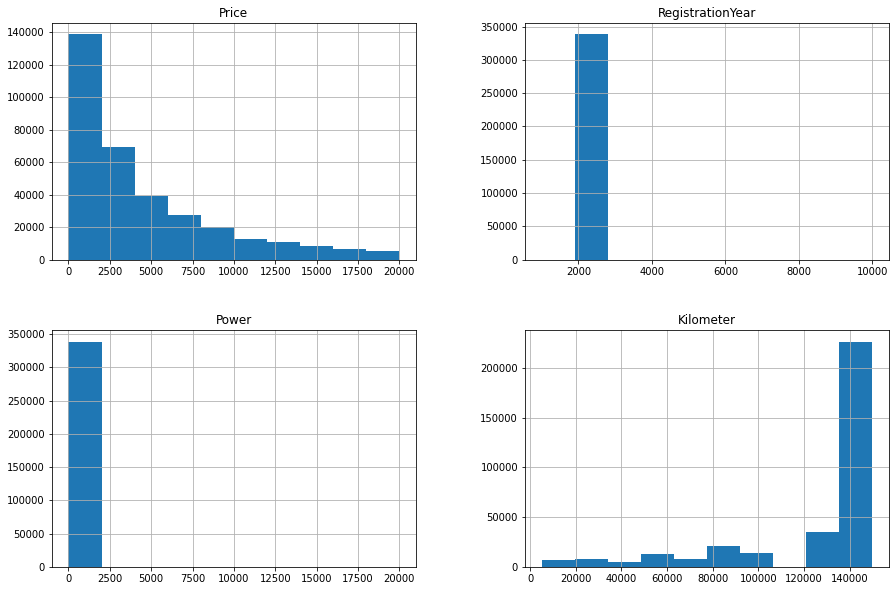

In [14]:
data.hist(figsize=(15,10))

<AxesSubplot:xlabel='Power', ylabel='Price'>

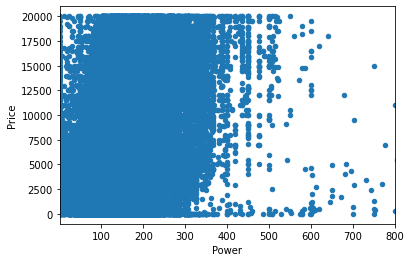

In [15]:
data.plot.scatter(x='Power', y='Price', xlim=(1, 800))

<AxesSubplot:>

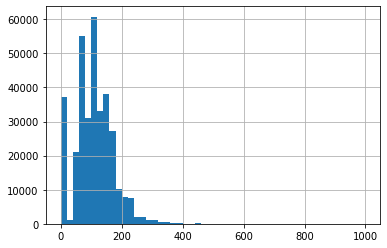

In [16]:
data[data['Power'] < 1000]['Power'].hist(bins=50)

In [17]:
data = data[(data['Power']<500) & (data['Power']>0)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301276 entries, 1 to 338510
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             301276 non-null  int64 
 1   VehicleType       290831 non-null  object
 2   RegistrationYear  301276 non-null  int64 
 3   Gearbox           295410 non-null  object
 4   Power             301276 non-null  int64 
 5   Model             289385 non-null  object
 6   Kilometer         301276 non-null  int64 
 7   FuelType          285429 non-null  object
 8   Brand             301276 non-null  object
 9   Repaired          256286 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.3+ MB


<b>Вывод</b>Значения близкие к 0 и выше 600л.с можно считать выбросами, данные строки можно удалить, с увеличением л.с не наблюдается рост цен, и автомобилей выше 1000-2500 л.с достаточно мало или вообще не существует    

### Удаление пропусков

In [18]:
data.isna().sum()

Price                   0
VehicleType         10445
RegistrationYear        0
Gearbox              5866
Power                   0
Model               11891
Kilometer               0
FuelType            15847
Brand                   0
Repaired            44990
dtype: int64

In [19]:
data[(data['Gearbox'].isna()) & (data['Repaired'].isna()) & (data['FuelType'].isna()) & (data['Model'].isna()) & (data['VehicleType'].isna())]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1259,650,NaN,1970,NaN,26,NaN,100000,NaN,trabant,NaN
1272,899,NaN,1990,NaN,37,NaN,60000,NaN,sonstige_autos,NaN
2656,2800,NaN,2005,NaN,150,NaN,150000,NaN,sonstige_autos,NaN
3655,300,NaN,2000,NaN,45,NaN,150000,NaN,opel,NaN
4618,0,NaN,2005,NaN,105,NaN,150000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
333837,399,NaN,2016,NaN,55,NaN,50000,NaN,skoda,NaN
333886,0,NaN,2006,NaN,170,NaN,150000,NaN,mercedes_benz,NaN
335701,20,NaN,1970,NaN,55,NaN,150000,NaN,opel,NaN
336836,1850,NaN,2000,NaN,89,NaN,150000,NaN,fiat,NaN


In [20]:
data = data.dropna(subset=['VehicleType', 'Gearbox', 'Model', 'Repaired','FuelType'], thresh=3)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296309 entries, 1 to 338510
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296309 non-null  int64 
 1   VehicleType       289546 non-null  object
 2   RegistrationYear  296309 non-null  int64 
 3   Gearbox           292469 non-null  object
 4   Power             296309 non-null  int64 
 5   Model             286800 non-null  object
 6   Kilometer         296309 non-null  int64 
 7   FuelType          284296 non-null  object
 8   Brand             296309 non-null  object
 9   Repaired          255719 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [21]:
data.isna().sum()

Price                   0
VehicleType          6763
RegistrationYear        0
Gearbox              3840
Power                   0
Model                9509
Kilometer               0
FuelType            12013
Brand                   0
Repaired            40590
dtype: int64

Просмотр уникальных значений в столбцах с пропущенными значениями

In [22]:
display('FuelType', data['FuelType'].unique())
display('VehicleType', data['VehicleType'].unique())
display('Gearbox', data['Gearbox'].unique())
display('Repaired', data['Repaired'].unique())
display('Model', data['Model'].unique())

'FuelType'

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'VehicleType'

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other', nan], dtype=object)

'Gearbox'

array(['manual', 'auto', nan], dtype=object)

'Repaired'

array(['yes', nan, 'no'], dtype=object)

'Model'

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'arosa', 'civic', 'transporter', 'punto', 'e_klasse',
       'kadett', 'one', 'fortwo', 'clio', '1er', 'b_klasse', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       'astra', '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a1',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er',
       'combo', 'corsa', '80', '147', 'meriva', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'ka',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       '6_reihe', 'c4', 'panda', 'up', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider',
       'cuore', 's_m

Пропущенные значения в 'FuelType' и 'VenicleType' можно определить как 'other', в остальных значение невозможно определить, однако количесвто пропусков достаточно высокое, чтобы удалять. В связи с этим пропуски заполним значениями 'unknown' 

In [23]:
data['FuelType'] = data['FuelType'].fillna('other')
data['VehicleType'] = data['VehicleType'].fillna('other')
data['Model'] = data['Model'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('unknown')
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [24]:
data['RegistrationYear'].sort_values().unique()

array([1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2900, 5000, 6000, 6500, 9000])

Необходимо удалить данные с годом выше 2019г.

In [25]:
data = data[data['RegistrationYear'] <= 2019].reset_index(drop=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296302 entries, 0 to 296301
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296302 non-null  int64 
 1   VehicleType       296302 non-null  object
 2   RegistrationYear  296302 non-null  int64 
 3   Gearbox           296302 non-null  object
 4   Power             296302 non-null  int64 
 5   Model             296302 non-null  object
 6   Kilometer         296302 non-null  int64 
 7   FuelType          296302 non-null  object
 8   Brand             296302 non-null  object
 9   Repaired          296302 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


<b>Вывод</b>Пропущенные значения удалены, а так же заменены на 'other' или 'unknown'

### Определение и преобразование признаков

In [27]:
RANDOM_STATE = 12345

In [28]:
features = data.drop('Price', axis=1)
target = data['Price']
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numerical = ['Power', 'Kilometer', 'RegistrationYear']

In [29]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                                       target, 
                                                                                       test_size=0.25,
                                                                                       random_state=RANDOM_STATE)

#### Линейная регрессия

Делим признаки на обучающую и тестовую выборку

In [30]:
features_train_lr, target_train_lr = features_train.copy(), target_train.copy()

In [31]:
#КОД РЕВЬЮЕРА
col_transform_lr = make_column_transformer(
   (StandardScaler(), numerical),
   (OneHotEncoder(drop='first'), categorical),
   remainder='passthrough')

features_train_lr = pd.DataFrame.sparse.from_spmatrix(col_transform_lr.fit_transform(features_train_lr), columns=col_transform_lr.get_feature_names_out())
features_train_lr

,standardscaler__Power,standardscaler__Kilometer,standardscaler__RegistrationYear,onehotencoder__VehicleType_convertible,onehotencoder__VehicleType_coupe,onehotencoder__VehicleType_other,onehotencoder__VehicleType_sedan,onehotencoder__VehicleType_small,onehotencoder__VehicleType_suv,onehotencoder__VehicleType_wagon,...,onehotencoder__Brand_smart,onehotencoder__Brand_sonstige_autos,onehotencoder__Brand_subaru,onehotencoder__Brand_suzuki,onehotencoder__Brand_toyota,onehotencoder__Brand_trabant,onehotencoder__Brand_volkswagen,onehotencoder__Brand_volvo,onehotencoder__Repaired_unknown,onehotencoder__Repaired_yes
0,1.351123,-0.767379,-0.410186,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.134893,-1.310350,-0.410186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.835823,-0.088665,-1.182172,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.574137,0.590048,2.060170,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.761056,-2.667777,0.824992,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222221,-1.134893,0.590048,-0.873378,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
222222,0.547373,0.590048,0.207403,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222223,-0.574137,-2.396292,1.596978,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222224,0.192228,0.590048,0.670595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Случайный лес

In [32]:
features_train_rf, target_train_rf = features_train.copy(), target_train.copy()

In [33]:
#Для модели решающее дерево и случайный лес необходимо использовать OrdinalEncoding
oe = OrdinalEncoder()
features_train_rf_final = pd.DataFrame(oe.fit_transform(features_train_rf[categorical]), columns=categorical, index=features_train_rf.index)
features_train_rf_final[numerical] = features_train_rf[numerical] 
target_train_rf_final = target_train_rf

#### LightGBM

In [34]:
#для модели LightGBM
features_train_gbm, target_train_gbm = features_train.copy(), target_train.copy()

features_train_gbm = features_train.copy()
target_train_gbm = target_train.copy()

sub_category = features_train_gbm.columns
for i in sub_category:
    if features_train_gbm[i].dtype == 'object':
        features_train_gbm[i] = features_train_gbm[i].astype('category')
features_train_gbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222226 entries, 237147 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       222226 non-null  category
 1   RegistrationYear  222226 non-null  int64   
 2   Gearbox           222226 non-null  category
 3   Power             222226 non-null  int64   
 4   Model             222226 non-null  category
 5   Kilometer         222226 non-null  int64   
 6   FuelType          222226 non-null  category
 7   Brand             222226 non-null  category
 8   Repaired          222226 non-null  category
dtypes: category(6), int64(3)
memory usage: 8.3 MB


<b>Вывод</b>
 - Для обучения модели Линейной Регрессии была выбрана технология OneHotEncoder
 - Для обучения другий моделей была выбрана технология OrdinalEncoder, в связи с большим количеством признаков по OneHotEncoder
 - Для обучения LightGBM необходимо было изменить тип данных категориальных переменных

## Обучение моделей

In [35]:
RANDOM_STATE = 12345

### Линейная Регресиия

Время обучения

In [36]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train_lr)

CPU times: user 17.9 s, sys: 22.6 s, total: 40.6 s
Wall time: 40.8 s


LinearRegression()

качество модели (RMSE)

In [37]:
cv_lr = cross_validate(LinearRegression(), features_train_lr, target_train_lr, scoring='neg_root_mean_squared_error', cv=3)
cv_lr

{'fit_time': array([25.29236221, 24.98793983, 29.88368988]),
 'score_time': array([0.20331025, 0.22184968, 0.20125532]),
 'test_score': array([-2635.83733304, -2641.33056386, -2662.56863117])}

### Случайный лес

In [38]:
features_train_rf_final.isna().sum()

VehicleType         0
Gearbox             0
Model               0
FuelType            0
Brand               0
Repaired            0
Power               0
Kilometer           0
RegistrationYear    0
dtype: int64

In [39]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
parametr = {'n_estimators' : range(10, 41, 10),
            'max_depth' : range(1, 8, 2),
            'min_samples_leaf' : range(1,8),
            'min_samples_split' : range(2,8,2)}

halving_rs = HalvingRandomSearchCV(estimator=model_rf,
                     param_distributions =parametr,
                     scoring='neg_root_mean_squared_error',
                     cv=3,
                     verbose=3)
halving_rs.fit(features_train_rf_final, target_train_rf_final)


rmse_rf = halving_rs.best_score_*-1
halving_rs.best_params_

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 10
min_resources_: 6
max_resources_: 222226
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 336
n_resources: 6
Fitting 3 folds for each of 336 candidates, totalling 1008 fits
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-3465.340, test=-4251.253) total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-962.376, test=-2901.667) total time=   0.0s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-1236.667, test=-3955.500) total time=   0.0s
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=(train=-3388.047, test=-4699.140) total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=(train=-1001.962, test=-2756.667) total time=   0.0s
[CV 3/3] END max_

/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 336 is smaller than n_iter=37037. Running 336 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=(train=-2815.785, test=-4468.356) total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=(train=-1164.268, test=-2785.000) total time=   0.0s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=(train=-753.622, test=-3574.833) total time=   0.0s
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=(train=-2710.036, test=-4482.612) total time=   0.0s
[CV 2/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=(train=-1174.674, test=-2707.083) total time=   0.0s
[CV 3/3] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=(train=-774.388, test=-3578.875) total time=   0.1s
[CV 1/3] END max_depth=1, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=(train=-6736.955, test=-3061.572) total time=  

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 7}

In [40]:
model_rf = RandomForestRegressor(max_depth=7, n_estimators=10, min_samples_split=2, min_samples_leaf=3, random_state=RANDOM_STATE)

In [41]:
cv_rf = cross_validate(model_rf, features_train_rf_final, target_train_rf_final, scoring='neg_root_mean_squared_error', cv=3)

<b>Второй раз не стал запускть, подбор парметров длительный процесс, значения и структуру подбора параметров закоментировал</b>

### LightGBM

In [42]:
model_lgbm = lgb.LGBMRegressor(random_state = RANDOM_STATE)
parametr = {'n_estimators' : range(10, 51, 10),
            'max_depth' : range(1, 10, 2),
            'num_leaves' : range(20,100,20)}

halving_lgbm = HalvingRandomSearchCV(estimator=model_lgbm,
                     param_distributions =parametr,
                     scoring='neg_root_mean_squared_error',
                     cv=3,
                     verbose=3)
halving_lgbm.fit(features_train_gbm, target_train_gbm)
rmse_lgbd = halving_lgbm.best_score_*-1
halving_lgbm.best_params_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 10
min_resources_: 6
max_resources_: 222226
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 6
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 100 is smaller than n_iter=37037. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END max_depth=1, n_estimators=10, num_leaves=20;, score=(train=-1526.587, test=-7450.966) total time=   0.8s
[CV 2/3] END max_depth=1, n_estimators=10, num_leaves=20;, score=(train=-4219.268, test=-1449.750) total time=   0.9s
[CV 3/3] END max_depth=1, n_estimators=10, num_leaves=20;, score=(train=-3391.534, test=-2500.000) total time=   1.0s
[CV 1/3] END max_depth=1, n_estimators=10, num_leaves=40;, score=(train=-1526.587, test=-7450.966) total time=   1.0s
[CV 2/3] END max_depth=1, n_estimators=10, num_leaves=40;, score=(train=-4219.268, test=-1449.750) total time=   0.9s
[CV 3/3] END max_depth=1, n_estimators=10, num_leaves=40;, score=(train=-3391.534, test=-2500.000) total time=   0.9s
[CV 1/3] END max_depth=1, n_estimators=10, num_leaves=60;, score=(train=-1526.587, test=-7450.966) total time=   1.0s
[CV 2/3] END max_depth=1, n_estimators=10, num_leaves=60;, score=(train=-4219.268, test=-1449.750) total time=   0.9s
[CV 3/3] END max_depth=1, n_estimators=10, num_leaves=60

{'num_leaves': 80, 'n_estimators': 50, 'max_depth': 9}

In [43]:
model_lgbm = lgb.LGBMRegressor(n_estimators=50, max_depth=9, num_leaves=80, random_state=RANDOM_STATE)


In [44]:
cv_lgbm = cross_validate(model_lgbm, features_train_gbm, target_train_gbm, scoring='neg_root_mean_squared_error', cv=3)

In [47]:
pd.DataFrame({'Время обучения, [s]':[cv_lr['fit_time'].mean(),cv_rf['fit_time'].mean(),cv_lgbm['fit_time'].mean()], 
              'Время предсказания, [s]':[cv_lr['score_time'].mean(),cv_rf['score_time'].mean(),cv_lgbm['score_time'].mean()], 
              'Качество модели RMSE':[cv_lr['test_score'].mean()*-1,cv_rf['test_score'].mean()*-1,cv_lgbm['test_score'].mean()*-1]},
            index=['Линейная регрессия', 'Случайный лес', 'LightGBM'])

,"Время обучения, [s]","Время предсказания, [s]",Качество модели RMSE
Линейная регрессия,26.721331,0.208805,2646.578843
Случайный лес,1.320868,0.041262,2175.650535
LightGBM,366.261603,0.541213,1691.653844


<b>Подобраны гиперпараметры, лучший показать по RMSE у <b>LightGBM: 1618</b>, у <b>Линейной Регрессии: 2640</b>, у модели <b>Случайный лес:2420</b> 

## Анализ моделей

In [48]:
features_test_gbm, target_test_gbm = features_test.copy(), target_test.copy()

sub_category = features_test_gbm.columns
for i in sub_category:
    if features_test_gbm[i].dtype == 'object':
        features_test_gbm[i] = features_test_gbm[i].astype('category')
features_train_gbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222226 entries, 237147 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       222226 non-null  category
 1   RegistrationYear  222226 non-null  int64   
 2   Gearbox           222226 non-null  category
 3   Power             222226 non-null  int64   
 4   Model             222226 non-null  category
 5   Kilometer         222226 non-null  int64   
 6   FuelType          222226 non-null  category
 7   Brand             222226 non-null  category
 8   Repaired          222226 non-null  category
dtypes: category(6), int64(3)
memory usage: 8.3 MB


In [54]:
model_lgbm.fit(features_train_gbm, target_train_gbm)
model_lgbm.predict(features_test_gbm)
rmse_lgbm_test = mean_squared_error(target_test_gbm, model_lgbm.predict(features_test_gbm))**0.5

In [55]:
rmse_lgbm_test

1678.3863193801935

RMSE на тестовой выборке выше чем на обучающей

<b>Выводы</b>
   - В начальном датасете присутствовали выбросы, и пропуски. Были удалены аномальные значения и заменены пропуски на категориальные переменные. Отношение размера конечного датасета к начальному составляет 86%  
   - Для обучения модели Линейной Регрессии была выбрана технология OneHotEncoder
   - Для обучения другий моделей была выбрана технология OrdinalEncoder, в связи с большим количеством признаков по OneHotEncoder
   - Для обучения LightGBM необходимо было изменить тип данных категориальных переменных
   - Наилучшей моделью является LightGBM 
               - Время обучени: 366 s
               - Время предсказания: 0.5 s
               - RMSE: 1678.38